In [1]:
!pip install torchmetrics
!pip install piqa
from piqa import MS_SSIM
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio 
from torchmetrics.classification import MulticlassAccuracy                                          
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from torchvision.io import read_image
from typing import Tuple,List,Callable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 7.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# use CUDA processors if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
def process_mat(directory: str, train: bool, test_files: list) -> Tuple[torch.Tensor, int, list, list]:
    # prepare feature data and image paths
    image_paths = []
    digits = []
    raw_data = None
    clean = f'{directory}/clean_split'
    num_features = 40
    for filename in os.listdir(clean): #iterate through the files in directory
        file = os.path.join(clean, filename)
        # checking if it is a file
        if os.path.isfile(file):
            if train:
                id = 'rain.pt'
            else:
                id = 'test.pt'
            if (filename[-7:] == id):
                if (id ==  'rain.pt') or (id == 'test.pt' and ((test_files == None) or (filename in test_files))):
                    data = torch.load(file)
                    features = data[0]
                    labels = data[1]
                    if (features.shape[1] == num_features):
                        if raw_data is None:
                            raw_data = features
                        else:
                            raw_data = np.append(raw_data, features, axis=0)
                    else:
                        print(f"IGNORED: {filename}")
                        continue
                    for i, y in enumerate(labels):
                        if not os.path.isfile(y[0]):
                            print(f"INGORED IMAGE: {y[0]}")
                            index = i - len(labels)
                            print(labels[index][0]==y[0])
                            print(raw_data.shape)
                            raw_data = np.delete(raw_data, index, 0)
                            continue
                        else:
                            image_paths.append(y[0])
                            digits.append(y[1])
                else:
                    continue
            else:
                continue
        else:
            raise Exception("this is not a file")
    print(type(raw_data))
    raw_data = torch.tensor(raw_data.astype(np.float32)).cuda()
    print(len(image_paths))
    return raw_data, num_features, image_paths, digits

In [5]:
# define data transformations
def feature_transform(x: torch.Tensor):
    # standardizes the features of a given data point
    mean = x.mean()
    std = x.std()
    return x.sub(mean).div(std)

def img_label_transform(y: str):
    # transforms an image path to a usable tensor
    image = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    convert_tensor = A.Compose([A.ToFloat(max_value=255), ToTensorV2()])
    try:
        thingy = convert_tensor(image=image)['image']
    except Exception as e:
        print(e)
        raise Exception(f"Image not found: {y}")
    return thingy.cuda()

def digit_label_transform(y: str):
    return torch.tensor(int(y)).cuda()

# create train and test Datasets and DataLoaders
class ReconstructionData(Dataset):
    def __init__(self, raw_features: torch.Tensor, labels: list, feature_transform, label_transform: None):
        self.features = raw_features
        self.labels = labels
        self.feature_transform = feature_transform
        self.label_transform = label_transform


    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        data = self.feature_transform(self.features[idx])
        label = self.label_transform(self.labels[idx])
        return data, label


def prep_data(train_features: torch.Tensor, train_labels: list, test_features: torch.Tensor, test_labels: list, label_transform, batch_size:int) -> Tuple[DataLoader, DataLoader]:
    # create train and test dataloaders
    train_data = ReconstructionData(train_features, train_labels, feature_transform, label_transform)
    test_data = ReconstructionData(test_features, test_labels, feature_transform, label_transform)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_dataloader,test_dataloader

In [6]:
class ImgReconstructNN(nn.Module):
    def __init__(self, num_features:int):
        super(ImgReconstructNN, self).__init__()
        self.linear_relu_deconv_stack = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.PReLU(),
            nn.Linear(512, 2048),
            nn.PReLU(),
            nn.Linear(2048, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )
    def forward(self, x):
        logits = self.linear_relu_deconv_stack(x)
        return logits

class ClassifyNN(nn.Module):
    def __init__(self, num_features:int):
        super(ClassifyNN, self).__init__()
        self.linear_relu_deconv_stack = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.PReLU(),
            nn.Linear(512, 2048),
            nn.PReLU(),
            nn.Linear(2048, 10),
            nn.LogSoftmax(1)
        )
    def forward(self, x):
        logits = self.linear_relu_deconv_stack(x)
        return logits

In [7]:
def create_model(num_features:int) -> nn.Module:
  model = ClassifyNN(num_features).to(device)
  print(model)
  return model

In [8]:
# Training loop
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer, print_loss: bool, loss_list: list) -> list:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= num_batches
    loss_list.append(train_loss)
    if print_loss:  
        print(f"Avg batch loss: {train_loss:>8f}")
    return loss_list

def img_test_loop(dataloader, model, loss_fn):
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):       
            print(f"batch: {batch+1}")     
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim

def digit_test_loop(dataloader, model, loss_fn, verbose):
    if verbose:
        print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_acc = 0
    acc = MulticlassAccuracy(num_classes=10).to(device)


    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):       
            probs = model(X)
            preds = torch.argmax(probs, dim=1)
            test_loss += loss_fn(probs, y).item()
            test_acc += acc(preds, y).item()

    test_loss /= num_batches
    test_acc /= num_batches
    if verbose:
        print(f"Avg batch loss: {test_loss:>8f}")
        print(f"Avg batch accuracy: {test_acc:>8f}")
    return model, test_loss, test_acc

In [9]:
def train_model(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
  train_losses = []
  test_losses = []
  test_accs = []
  for t in range(epochs):
      print_loss = False
      if (t % 8 == 7) or (t==0):
        print_loss = True
        print("-------------------------------")
        print(f"Epoch {t+1}")
      train_losses = train_loop(train_dataloader, model, loss_fn, optimizer, print_loss, train_losses)
      _, test_loss, test_acc = digit_test_loop(test_dataloader, model, loss_fn, False)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  print("Done!")
  return train_losses, test_losses, test_accs

In [10]:
# Validation Results:
#  32-epoch loss: 0.014299
#  48-epoch loss: 0.013660 
#  64-epoch loss: 0.013298
#  80-epoch loss: 0.013655 
#  96-epoch loss: 0.013975
# 128-epoch loss: 0.014216
# 192-epoch loss: 0.015130

In [11]:
def plot_loss(result, ylbl, title) -> None:
    result = np.array(torch.tensor(result).cpu())
    plt.plot(result, color='red')
    plt.ylabel(ylbl) #set the label for y axis
    plt.xlabel('Epoch') #set the label for x-axis
    plt.title(title) #set the title of the graph
    plt.show() #display the graph

In [12]:
def run(directory: str, test_files, batch_size, loss_fn, learning_rate, epochs: int):
    print("PART 1")
    train_data, num_features, train_image_paths, train_digits = process_mat(directory, True, None)
    print("PART 2")
    test_data, num_features, test_image_paths, test_digits = process_mat(directory, False, None)
    print("PART 3")
    train_dataloader, test_dataloader = prep_data(train_data, train_digits, test_data, test_digits, digit_label_transform, batch_size)
    print("PART 4")
    model = create_model(num_features)
    print("PART 5")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print("PART 6")
    train_losses, test_losses, test_accs = train_model(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs)
    print("PART 7")
    plot_loss(train_losses, "Average Batch Loss", "Training Loss over Training Epochs")
    plot_loss(test_losses, "Average Batch Loss", "Testing Loss over Training Epochs")
    plot_loss(test_accs, "Average Batch Accuracy", "Testing Accuracy over Training Epochs")
    print("PART 8")
    model, test_loss, test_acc = digit_test_loop(test_dataloader, model, loss_fn, True)
    return model, train_losses, test_loss, test_acc

In [13]:
l1 = nn.L1Loss()
class L1_SSIM_loss(MS_SSIM):
    def forward(self, x, y):
        return (0.5 * (1. - super().forward(x, y))) + (0.5 * l1.forward(x, y))

criterion = L1_SSIM_loss(window_size=2, n_channels=1).cuda()

In [14]:
# prepare directories
main_dir = '/content/drive/MyDrive/superresolution/nonlinear_classification'
data_dir = f'{main_dir}/data/features/SIM_by_crystal'
image_dir = f'{main_dir}/data/digit_image'

# hyper-parameters:
batch_size = 50
learning_rate = 1e-3
epochs = 96
loss_fn = nn.CrossEntropyLoss() #criterion

# sample_dir = f'{data_dir}/original_EXP_data/with_noise/ChangeCrystalPosition_DATA/shiftCrystal40mm_SNR17(s10)_1-200samples_40LG_10loop_Oct12'
# run(sample_dir, test_size, batch_size, loss_fn, learning_rate, epochs)

In [15]:
# 64 Epoch piqa
# Avg batch loss: 0.084998
# Avg batch PSNR: 15.341266
# Avg batch SSIM: 0.573755

# 128 Epoch piqa
# Avg batch loss: 0.063156
# Avg batch PSNR: 16.070961
# Avg batch SSIM: 0.636266

# 256 epoch 1/2 SSIM 1/2 MAE
# Avg batch loss: 0.057746
# Avg batch PSNR: 17.995046
# Avg batch SSIM: 0.764595

PART 1
IGNORED: 1-200samples_105LG_N800_dx5.2_s10_sameSNR15_27mm_train.pt
IGNORED: 1-200samples_112LG_N800_dx5.2_s10_sameSNR10_27mm_train.pt
IGNORED: changeCrystalPosition_27mm_49HG_1-200sample_digit800_dx5.2_train.pt
<class 'numpy.ndarray'>
11200
PART 2
IGNORED: 1-200samples_105LG_N800_dx5.2_s10_sameSNR15_27mm_test.pt
IGNORED: 1-200samples_112LG_N800_dx5.2_s10_sameSNR10_27mm_test.pt
IGNORED: changeCrystalPosition_27mm_49HG_1-200sample_digit800_dx5.2_test.pt
<class 'numpy.ndarray'>
2800
PART 3
PART 4
ClassifyNN(
  (linear_relu_deconv_stack): Sequential(
    (0): Linear(in_features=40, out_features=512, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=2048, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
PART 5
PART 6
-------------------------------
Epoch 1
Avg batch loss: 2.080448
-------------------------------
Epoch 8
Avg batch loss: 1.375842
-----------

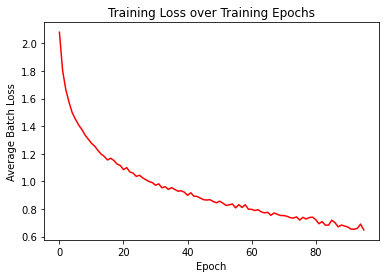

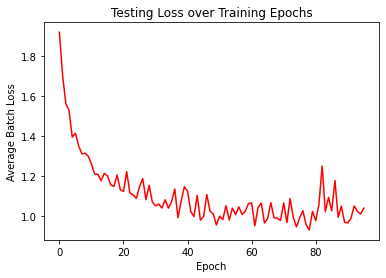

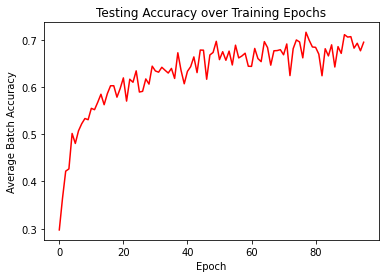

PART 8
Running Test Loop
Avg batch loss: 1.040576
Avg batch accuracy: 0.684303


In [16]:
sample_dir = f'{data_dir}/27mm'
model, train_loss, test_loss, test_acc = run(sample_dir, None, batch_size, loss_fn, learning_rate, epochs)
filename = f'{sample_dir}/model.pt'
torch.save(model.state_dict(), filename)
filename = f'{sample_dir}/train_loss.pt'
torch.save(train_loss, filename)
filename = f'{sample_dir}/test_loss.pt'
torch.save(test_loss, filename)
filename = f'{sample_dir}/test_acc.pt'
torch.save(test_acc, filename)

PART 1
IGNORED: 1-200samples_49HG_N800_dx5.2_s20_sameSNR10_0.8f_train.pt
IGNORED: changeCrystalPosition_f0.8_49HG_1-200sample_digit800_dx5.2_train.pt
<class 'numpy.ndarray'>
14400
PART 2
IGNORED: 1-200samples_49HG_N800_dx5.2_s20_sameSNR10_0.8f_test.pt
IGNORED: changeCrystalPosition_f0.8_49HG_1-200sample_digit800_dx5.2_test.pt
<class 'numpy.ndarray'>
3600
PART 3
PART 4
ClassifyNN(
  (linear_relu_deconv_stack): Sequential(
    (0): Linear(in_features=40, out_features=512, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=2048, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
PART 5
PART 6
-------------------------------
Epoch 1
Avg batch loss: 1.718370
-------------------------------
Epoch 8
Avg batch loss: 0.657429
-------------------------------
Epoch 16
Avg batch loss: 0.525965
-------------------------------
Epoch 24
Avg batch loss: 0.453619
--------------

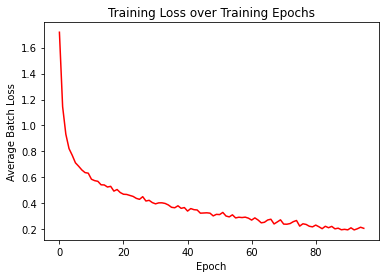

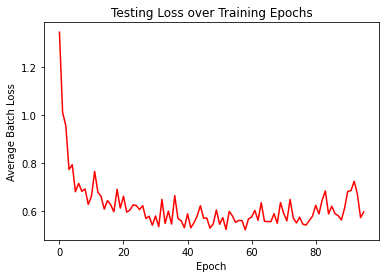

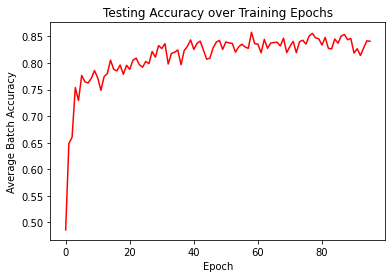

PART 8
Running Test Loop
Avg batch loss: 0.597094
Avg batch accuracy: 0.842482


In [17]:
sample_dir = f'{data_dir}/0.8f'
model, train_loss, test_loss, test_acc = run(sample_dir, None, batch_size, loss_fn, learning_rate, epochs)
filename = f'{sample_dir}/model.pt'
torch.save(model.state_dict(), filename)
filename = f'{sample_dir}/train_loss.pt'
torch.save(train_loss, filename)
filename = f'{sample_dir}/test_loss.pt'
torch.save(test_loss, filename)
filename = f'{sample_dir}/test_acc.pt'
torch.save(test_acc, filename)

PART 1
INGORED IMAGE: /content/drive/MyDrive/superresolution/nonlinear_classification/data/digit_image/9/image8998.png
True
(1600, 40)
INGORED IMAGE: /content/drive/MyDrive/superresolution/nonlinear_classification/data/digit_image/9/image8988.png
True
(1599, 40)
INGORED IMAGE: /content/drive/MyDrive/superresolution/nonlinear_classification/data/digit_image/9/image8978.png
True
(1598, 40)
INGORED IMAGE: /content/drive/MyDrive/superresolution/nonlinear_classification/data/digit_image/9/image8968.png
True
(1597, 40)
INGORED IMAGE: /content/drive/MyDrive/superresolution/nonlinear_classification/data/digit_image/9/image8993.png
True
(1596, 40)
INGORED IMAGE: /content/drive/MyDrive/superresolution/nonlinear_classification/data/digit_image/9/image8983.png
True
(1595, 40)
INGORED IMAGE: /content/drive/MyDrive/superresolution/nonlinear_classification/data/digit_image/9/image8973.png
True
(1594, 40)
IGNORED: fontsize-pixel200_area100_amp200_noisecluster10_104LG_dx7.5_train.pt
IGNORED: fontsize-p

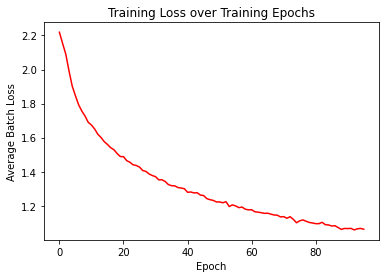

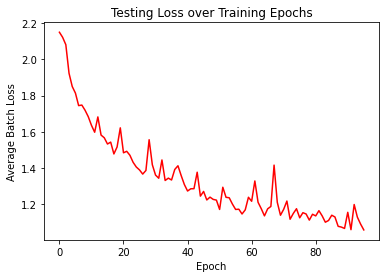

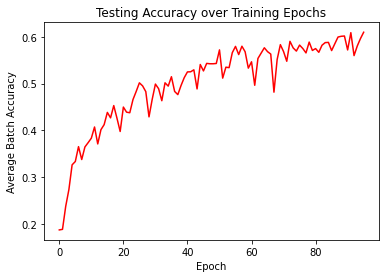

PART 8
Running Test Loop
Avg batch loss: 1.059821
Avg batch accuracy: 0.612702


In [18]:
sample_dir = f'{data_dir}/1f'
model, train_loss, test_loss, test_acc = run(sample_dir, None, batch_size, loss_fn, learning_rate, epochs)
filename = f'{sample_dir}/model.pt'
torch.save(model.state_dict(), filename)
filename = f'{sample_dir}/train_loss.pt'
torch.save(train_loss, filename)
filename = f'{sample_dir}/test_loss.pt'
torch.save(test_loss, filename)
filename = f'{sample_dir}/test_acc.pt'
torch.save(test_acc, filename)